### A set of scripts to simulate landscape evolution of a scarp over a desired timescale using non-linear diffusion

Non-linear implementation based on Abel Hafiz's MSc code

### User defined options

In [28]:
DEM_name = 'DEMs/R1.asc' # set name of your DEM here 
total_time = 1000 # set total time of simulation in years here, code will output diffused scarp over that timescale
#file_name_export = 'eroded_DEMs/Ridgecrest2_eroded.asc' # set name of output synthetic DEM here

### Import Python packages and Landlab tools

Landlab docs: https://landlab.readthedocs.io/en/latest/reference/components/taylor_nonlinear_hillslope_flux.html

In [29]:
from landlab.components import TaylorNonLinearDiffuser
from landlab import RasterModelGrid
import numpy as np
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
import decimal

### load DEM 

/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:535: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:984: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `

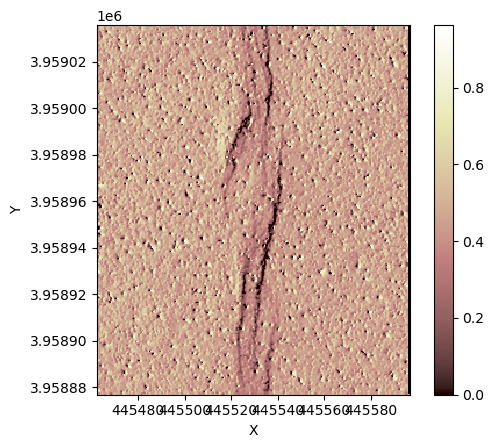

In [30]:
# load DEM -- uses some landlab commands
mg_nonlinear, z_nonlinear = read_esri_ascii(DEM_name, name='topographic__elevation')
np.all(mg_nonlinear.at_node['topographic__elevation'] == z_nonlinear)
mg_nonlinear.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg_nonlinear.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg_nonlinear.calc_hillshade_at_node(elevs=z_nonlinear, alt=30., az=100.)
imshow_grid(mg_nonlinear,hillshade)


### Define 2D diffusion set-up

We define our transport rate and 2D diffusion set-up (using the non-linear diffusion implementation from landlab)

In [31]:
mg_nonlinear.set_closed_boundaries_at_grid_edges(True, True, True, True)
D = 0.001 # m^2/yr
dt = 1
cubicflux = TaylorNonLinearDiffuser(mg_nonlinear, linear_diffusivity=D, if_unstable="warn",dynamic_dt=True,nterms=2) #nterms from Ganti et al. (2012)

### Simulate diffusion

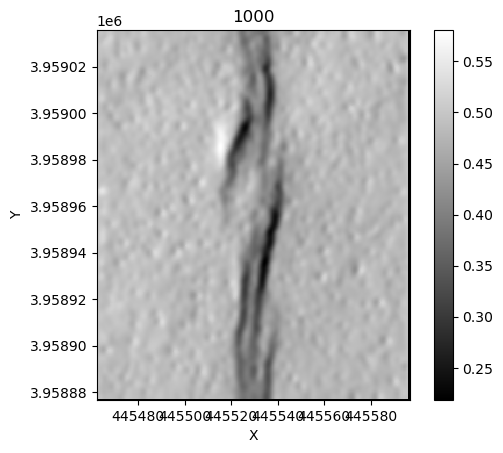

In [32]:
# option to visualize and double check 
cubicflux.run_one_step(dt)

for i in range(total_time):
    cubicflux.run_one_step(dt) # transport limited diffusion

hillshade = mg_nonlinear.calc_hillshade_at_node(elevs=z_nonlinear, alt=30., az=100.)
imshow_grid(mg_nonlinear,hillshade,cmap='gray')
plt.title(total_time)
z_nonlinear =  z_nonlinear[mg_nonlinear.nodes]

### Export synthetic DEM after diffusion

as an ascii file

In [33]:
#write_esri_ascii(file_name_export, mg)

### Compare linear and nonlinear diffusion

In [34]:
# run linear diffusion 
mg_linear, z_linear = read_esri_ascii(DEM_name, name='topographic__elevation')
np.all(mg_linear.at_node['topographic__elevation'] == z_linear)
mg_linear.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg_linear.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg_linear.calc_hillshade_at_node(elevs=z_linear, alt=30., az=100.)
slope_t0 = mg_linear.calc_slope_at_node(z_linear)
z_t0 = z_linear[mg_linear.nodes]

D = 0.001  # m2/yr transport coefficient (0.001 m2/yr for Basin and Range)
dt = 0.2 * mg_linear.dx * mg_linear.dx / D # set time step to 50 yrs
mg_linear.set_closed_boundaries_at_grid_edges(True, True, True, True)
qs = mg_linear.add_zeros('sediment_flux', at='link')

n_iter = int(total_time/dt)

for p in range(n_iter):
    g = mg_linear.calc_grad_at_link(z_linear)
    qs[mg_linear.active_links] = -D * g[mg_linear.active_links]
    dzdt = -mg_linear.calc_flux_div_at_node(qs)
    z_linear[mg_linear.core_nodes] += dzdt[mg_linear.core_nodes] * dt

z_linear =  z_linear[mg_linear.nodes]

Text(0.5, 1.0, 'Time = 1000 years')

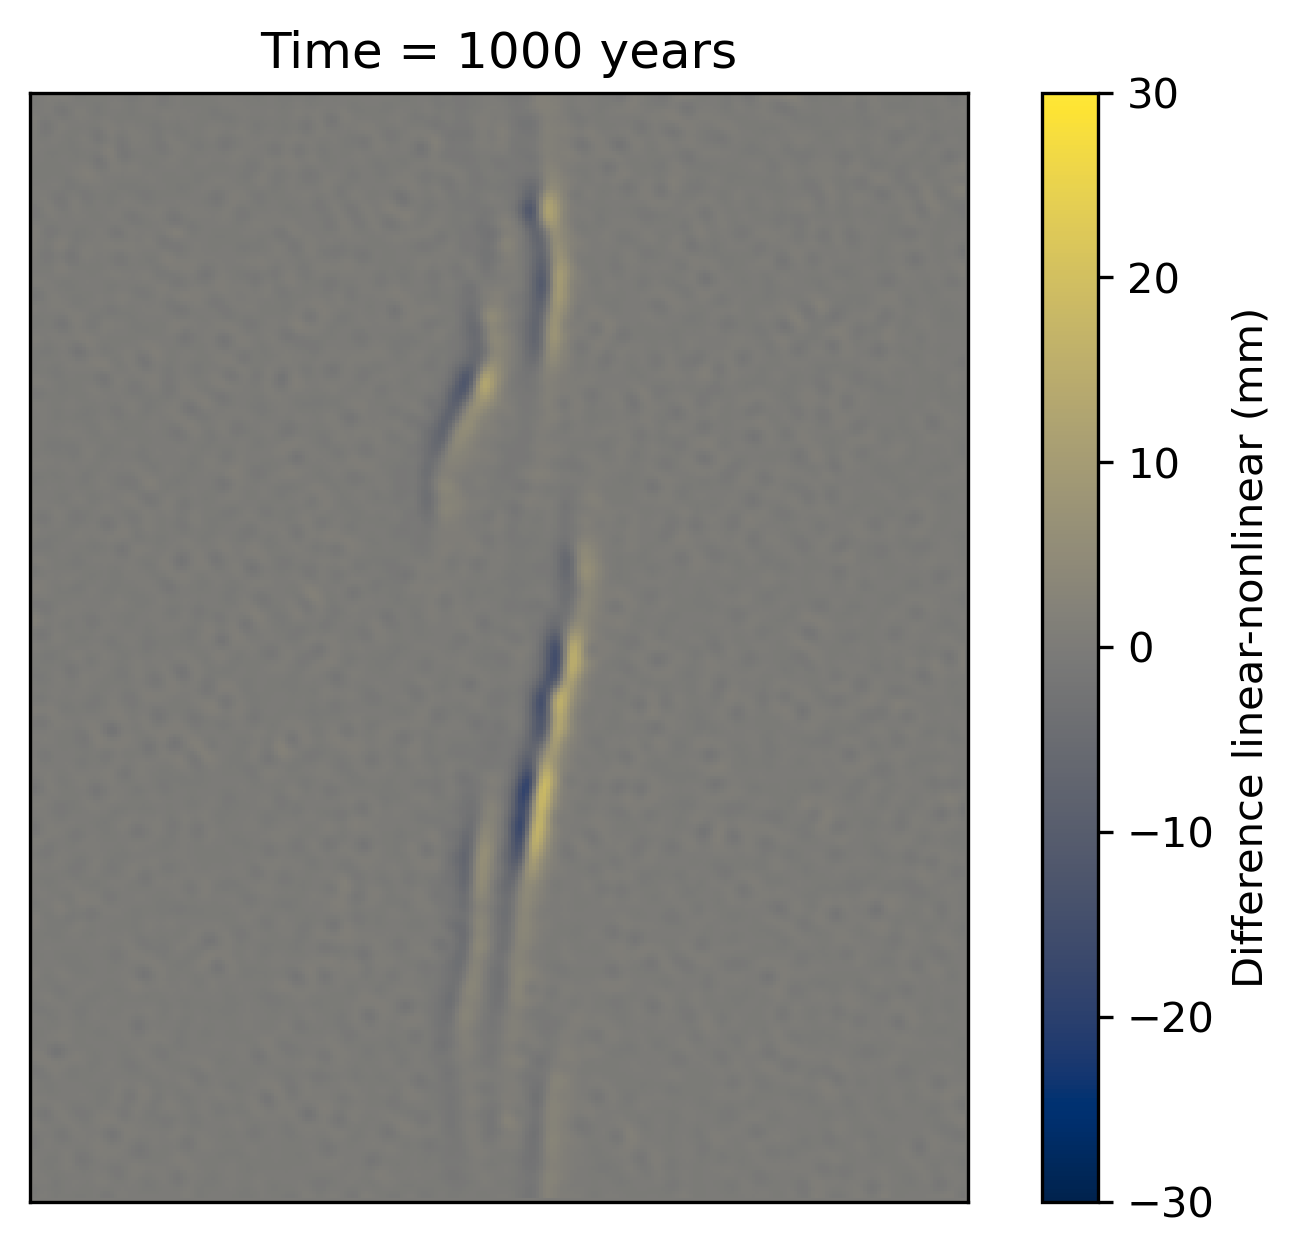

In [35]:
zdiff = z_linear - z_nonlinear
zchange = mg_nonlinear.node_vector_to_raster(zdiff, flip_vertically=True)
plt.figure(dpi=300)
plt.imshow(zchange*1000,cmap='cividis',vmin=-30,vmax=30)
colorbar = plt.colorbar()
colorbar.set_label('Difference linear-nonlinear (mm)')
plt.yticks([])
plt.xticks([])
plt.title(f'Time = {total_time} years')